In [1]:
#https://hunkim.github.io/ml/ > 타임시리즈 RNN
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
'''
This script shows how to predict stock prices using a basic RNN
'''
import tensorflow as tf
import numpy as np
import matplotlib
import os

tf.set_random_seed(777)  # reproducibility
#tf.random.set_seed(777)

# if "DISPLAY" not in os.environ:
#     # remove Travis CI Error
#     matplotlib.use('Agg')

def MinMaxScaler(data):
    ''' Min Max Normalization

    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]

    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]

    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [3]:
# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
print(xy)
xy = xy[::-1]  # reverse order (chronically ordered)

# train/test split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

print()
print(train_set)

[[8.28659973e+02 8.33450012e+02 8.28349976e+02 1.24770000e+06
  8.31659973e+02]
 [8.23020020e+02 8.28070007e+02 8.21655029e+02 1.59780000e+06
  8.28070007e+02]
 [8.19929993e+02 8.24400024e+02 8.18979980e+02 1.28170000e+06
  8.24159973e+02]
 ...
 [5.66892592e+02 5.67002574e+02 5.56932537e+02 1.08000000e+04
  5.56972503e+02]
 [5.61202549e+02 5.66432590e+02 5.58672539e+02 4.12000000e+04
  5.59992565e+02]
 [5.68002570e+02 5.68002570e+02 5.52922516e+02 1.31000000e+04
  5.58462551e+02]]

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 ...
 [8.39570954e-01 8.39838972e-01 8.87125813e-01 1.00779780e-01
  8.63403284e-01]
 [8.31877329e-01 8.51543969e-01 8.87806004e-01 9.37348750e-02
  8.91180354e-01]
 [8.64998078e-01 8.54129989e-01 8.90383639e-01 1.29541992e-01
  8.72134355e-01]]


In [4]:
# import tensorflow.compat.v1 as tf_v1
# tf_v1.disable_v2_behavior()

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
#X = tf_v1.placeholder(tf.float32, [None, seq_length, data_dim])
#Y = tf_v1.placeholder(tf.float32, [None, 1])
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

print(X)
print()
print(Y)

Tensor("Placeholder:0", shape=(?, 7, 5), dtype=float32)

Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [5]:
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.


In [6]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        if i % 50 == 0:
            print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

[step: 0] loss: 166.2140655517578
[step: 50] loss: 1.587686538696289
[step: 100] loss: 1.2327989339828491
[step: 150] loss: 1.1381456851959229
[step: 200] loss: 1.0413328409194946
[step: 250] loss: 0.948056697845459
[step: 300] loss: 0.8704195618629456
[step: 350] loss: 0.8121415972709656
[step: 400] loss: 0.7684662342071533
[step: 450] loss: 0.7330562472343445
RMSE: 0.05135541409254074


In [7]:
print(testY[0:10])
print()
print(test_predict[0:10])

[[0.42345156]
 [0.40523252]
 [0.44698661]
 [0.49853637]
 [0.50737719]
 [0.54202261]
 [0.58747978]
 [0.51173763]
 [0.50421114]
 [0.54285897]]

[[0.44343463]
 [0.43870452]
 [0.43243715]
 [0.4334444 ]
 [0.49341163]
 [0.5181849 ]
 [0.54124516]
 [0.5782435 ]
 [0.5554106 ]
 [0.5283018 ]]


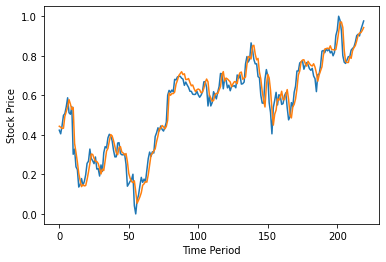

In [8]:
import matplotlib.pyplot as plt

# Plot predictions
plt.plot(testY)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()